<a href="https://colab.research.google.com/github/NdiemaJacob/artificial-intelligence-/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
# Load data
import os
print(os.listdir('/content'))
# print(os.listdir('/content/creditcardfraud')) # This line caused the error

df = pd.read_csv('/content/creditcard.csv.zip')
print(f"Data shape: {df.shape}")
print(f"Fraud rate: {df['Class'].mean():.4f}")

['.config', 'creditcard.csv.zip', 'sample_data']
Data shape: (284807, 31)
Fraud rate: 0.0017


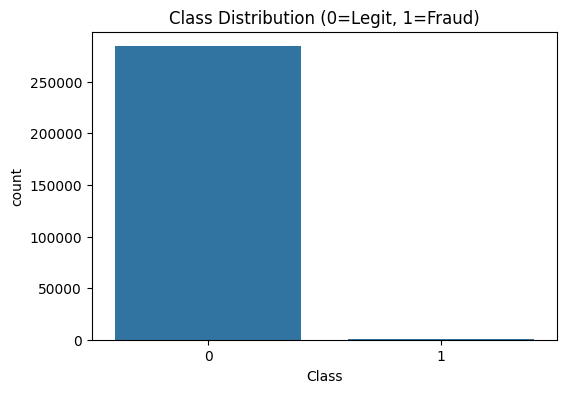

In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0=Legit, 1=Fraud)')
plt.show()

# Scale 'Amount' and 'Time' (other features are PCA-transformed)
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

Train fraud rate: 0.0017
Test fraud rate: 0.0017
Train fraud rate: 0.0017
Test fraud rate: 0.0017


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 316, number of negative: 181960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info

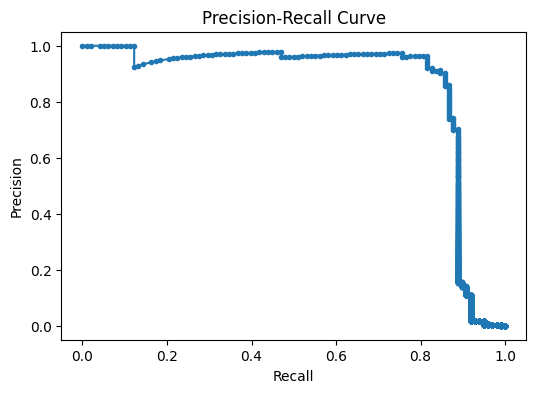

In [ ]:
from sklearn.ensemble import StackingClassifier

# Base models
base_models = [
    ('lgbm', LGBMClassifier(random_state=42, class_weight='balanced')),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000)

# Stacked ensemble
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba'
)
stacked_model.fit(X_train, y_train)

# Evaluate
y_pred = stacked_model.predict(X_test)
print("=== Stacked Ensemble Performance ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, stacked_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

=== Balanced Random Forest + SMOTE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56856     8]
 [   19    79]]


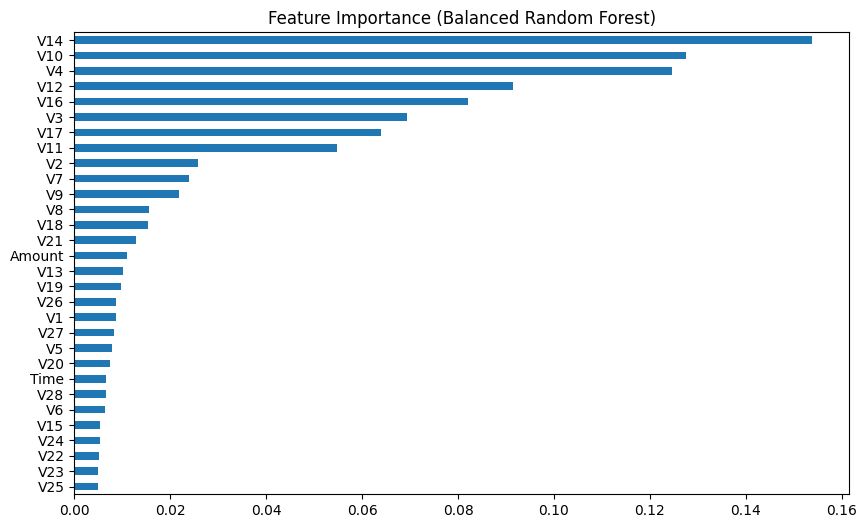

In [ ]:
# SMOTE oversampling (only on training data!)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    sampling_strategy='auto',
    replacement=True
)
brf.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred_brf = brf.predict(X_test)
print("=== Balanced Random Forest + SMOTE ===")
print(classification_report(y_test, y_pred_brf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_brf))

# Feature Importance
plt.figure(figsize=(10, 6))
pd.Series(brf.feature_importances_, index=X.columns).sort_values().plot.barh()
plt.title('Feature Importance (Balanced Random Forest)')
plt.show()

In [ ]:
from sklearn.metrics import recall_score

print("\n=== Model Comparison ===")
print("Stacked Ensemble Recall:", recall_score(y_test, y_pred))
print("Balanced RF + SMOTE Recall:", recall_score(y_test, y_pred_brf))